In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
from math import *
import time
from PIL import Image

import copy

# Utility functions, loading task

In [7]:
maze = 1*(np.array(Image.open("maze.png"))[:,:,0]>0)

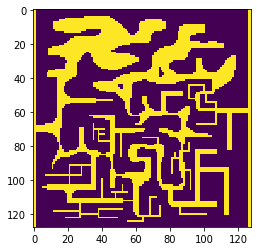

In [8]:
plt.imshow(maze, interpolation='nearest')

In [ ]:
def diminishingMean(x):
    z = np.sort(x)
    w = np.exp(np.clip(0.5*(np.arange(x.shape[0])-x.shape[0]+1), -30, 0))
    
    return np.sum(w*z)/np.sum(w)

def diversity(x):
    dist = np.sqrt(np.sum((x[np.newaxis,:,:]-x[:,np.newaxis,:])**2,axis=2))
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])
    
    return np.min(dist,axis=0).mean()

def mutate(p):
    return p + np.array([(2*np.random.rand()-1),(2*np.random.rand()-1),0])

def mutate2(p):
    return p + np.array([(2*np.random.rand()-1),(2*np.random.rand()-1)])

def projection(p):
    return p

def fitness(p):
    f = p[1]
    if p[0]<0 or p[1]<0 or p[0]>=maze.shape[0] or p[1]>=maze.shape[1]:
        f -= 100000
    else:
        if maze[int(p[0]), int(p[1])]<0.5:
            f -= 100000
    
    return f

def fitness0(p):
    return 0

# MAP-Elites

In [213]:
class MAPElites():
    def __init__(self, RESOLUTION = 16, NICHE_POP = 1, xmin=0, xmax=128, ymin=0, ymax=128):
        self.niches = [ [ [] for i in range(RESOLUTION) ] for j in range(RESOLUTION) ]
        self.NICHE_POP = NICHE_POP
        self.RESOLUTION = RESOLUTION
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    
    def add(self, x, projection):
        z = projection(x)
            
        i = int(np.clip( self.RESOLUTION*(z[0]-self.xmin)/(self.xmax-self.xmin), 0, self.RESOLUTION-1))
        j = int(np.clip( self.RESOLUTION*(z[1]-self.ymin)/(self.ymax-self.ymin), 0, self.RESOLUTION-1))
        
        self.niches[i][j].append(x)
    
    def step(self, mutation, projection, fitness):
        pop = []
        for n in self.niches:
            for n2 in n:
                pop = pop + n2
        
        #w = 1+np.array([p[2]**2 for p in pop])
        #w = w/np.sum(w)
        
        for p in pop:
            #p = pop[np.random.choice(np.arange(len(pop)), p=w)]
            p2 = mutation(p)
            #p2[2] = 0
            z2 = projection(p2)
            f2 = fitness(p2)
            
            if f2>=0:
                i = int(np.clip( self.RESOLUTION*(z2[0]-self.xmin)/(self.xmax-self.xmin), 0, self.RESOLUTION-1))
                j = int(np.clip( self.RESOLUTION*(z2[1]-self.ymin)/(self.ymax-self.ymin), 0, self.RESOLUTION-1))

                n2 = self.niches[i][j]
                if len(n2)<self.NICHE_POP:
                    p[2] += 1
                    self.niches[i][j].append(p2)
                else:
                    k = np.random.randint(len(n2))
                    fits1 = np.array([fitness(n) for n in n2])
                    proj1 = np.array([projection(n) for n in n2])
                    
                    fits2 = fits1.copy()
                    fits2[k] = f2
                    
                    proj2 = proj1.copy()
                    proj2[k] = z2
                    
                    if diminishingMean(fits2) + 10*diversity(proj2) > diminishingMean(fits1) + 10*diversity(proj1):
                        p[2] += 1
                        self.niches[i][j][k] = p2

In [217]:
pop = MAPElites(RESOLUTION=32, NICHE_POP=8)
pop.add(np.array([64,0,0]), projection)

mkdir: cannot create directory ‘frames’: File exists


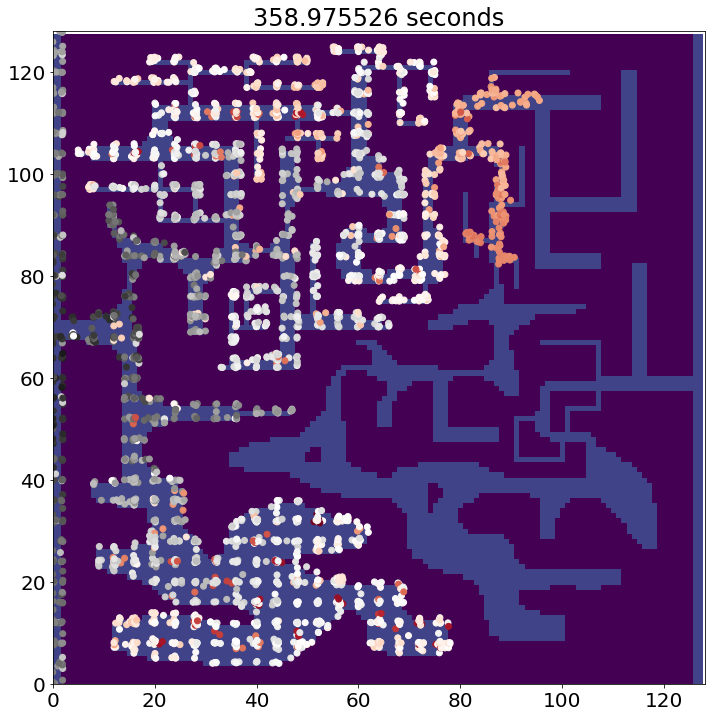

In [218]:
#!mkdir frames
#!rm frames/*.png

frame = 0
t0 = time.time()

plt.rcParams['font.size'] = 20

step = 0
while time.time()-t0<360:
    pop.step(mutate, projection, fitness)
    
    if step%20 == 0:
        allpop = []
        for n in pop.niches:
            for n2 in n:
                allpop = allpop + n2
        allpop = np.array(allpop)

        plt.clf()
        plt.imshow(maze, vmin=0,vmax=5)
        plt.scatter(allpop[:,1], allpop[:,0], c=allpop[:,2], cmap=plt.cm.RdGy_r)
        plt.xlim(0,128)
        plt.ylim(0,128)
        plt.gcf().set_size_inches((12,12))
        plt.gcf().set_facecolor("white")
        plt.title("%.6f seconds" % (time.time()-t0))
        plt.savefig("frames/%.6d.png" % frame)
        frame += 1
    step += 1

# Spanning Population stuff...

In [219]:
def spanPopulation(N, population, fitness, steps=100, alpha=2):
    zs = np.array([s for s in population])
    dist = np.power(np.sum((zs[np.newaxis,:,:2]-zs[:,np.newaxis,:2])**2, axis=2), 1.0/alpha)
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])        
    
    def evalDist(sp):
        subdist = dist[sp[:,np.newaxis], sp[np.newaxis,:]]        
        mindist = np.min(subdist,axis=0)
        return np.mean(mindist) + 0.01 * diminishingMean(np.array([fitness(population[i]) for i in sp]))
    
    if N>len(population):
        return population, 0
    
    subpop = np.arange(N)#random.permutation(len(population))[:N]
    score = evalDist(subpop)
    
    for i in range(steps):
        subpop2 = subpop.copy()
        for j in range(1):
            k = np.random.randint(N)
            subpop2[k] = -1
            
            l = np.random.randint(len(population))
            while l in subpop2:
                l = np.random.randint(len(population))
                
            subpop2[k] = l
        
        score2 = evalDist(subpop2)
        
        if score2>score:
            subpop = subpop2
            score = score2
    
    subdist = dist[subpop[:,np.newaxis], subpop[np.newaxis,:]]        
    mindist = np.min(subdist,axis=0)
    
    return [population[i] for i in subpop], mindist.mean()

# Spanning population (occasional update of span)

In [221]:
population = [np.array([64,0]) for i in range(64)]

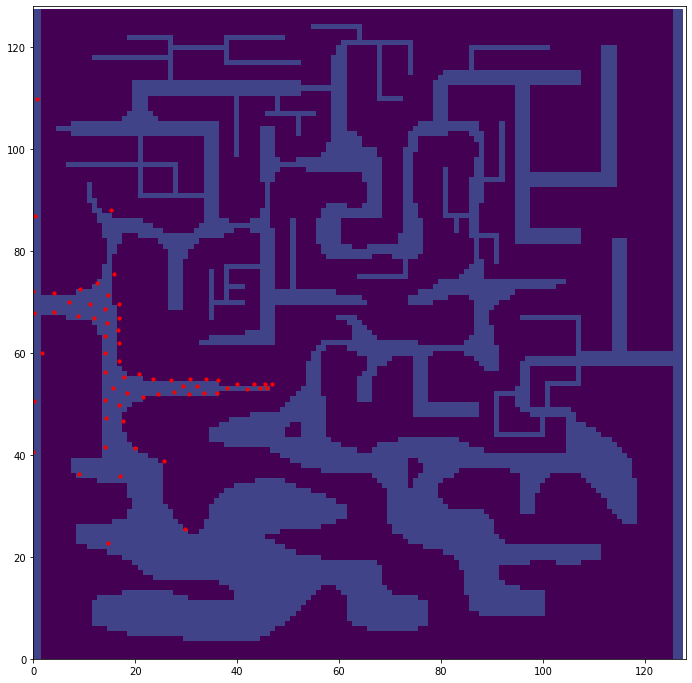

KeyboardInterrupt: 

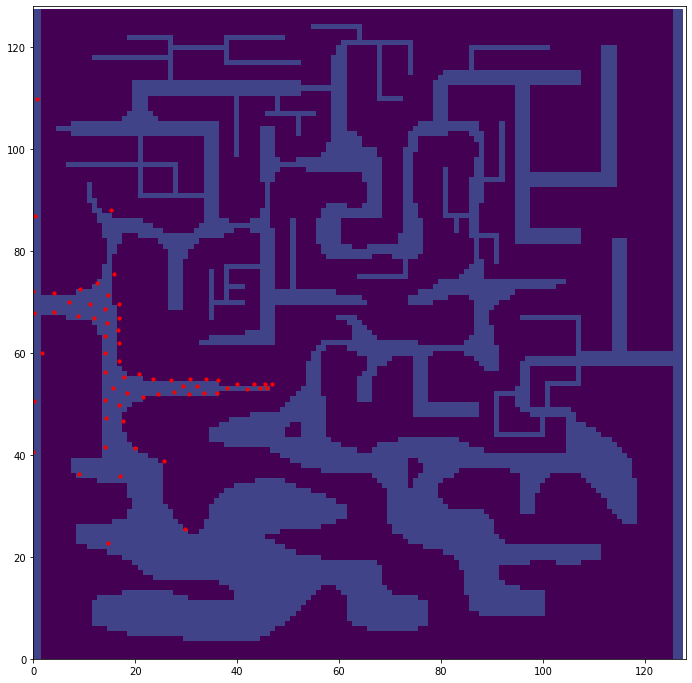

In [52]:
for step in range(1000):       
    while len(population)<1024:
        p = mutate2(population[np.random.randint(len(population))])        
        f = fitness(p)
        if f>=0:
            population.append(p)
    population, _ = spanPopulation(64, population, fitness, steps=1000)
    
    if step%10 == 0:
        plt.clf()
        plt.imshow(maze, vmin=0,vmax=5)
        plt.scatter(np.array(population)[:,1], np.array(population)[:,0], c='r', s=10)
        plt.xlim(0,128)
        plt.ylim(0,128)
        plt.gcf().set_size_inches((12,12))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)


# Spanning population (continuous updating of span)

In [ ]:
population = [np.array([64,0]) for i in range(256)]

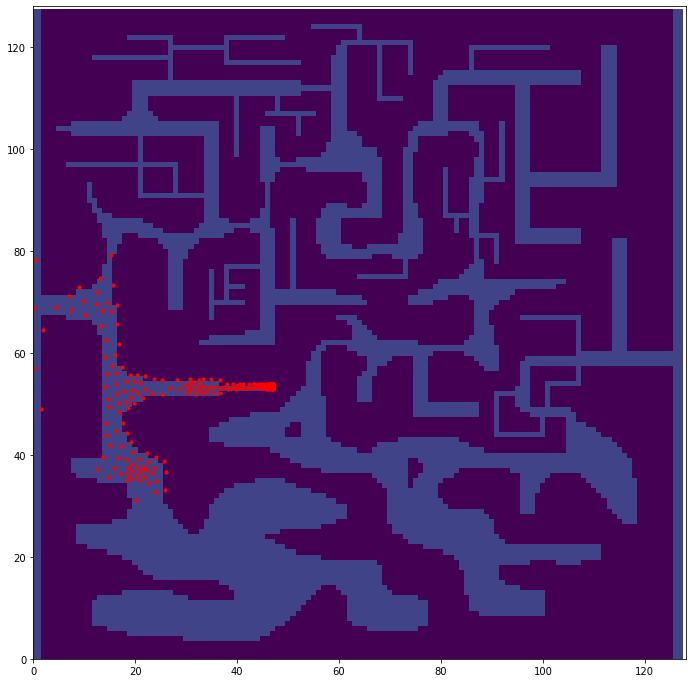

KeyboardInterrupt: 

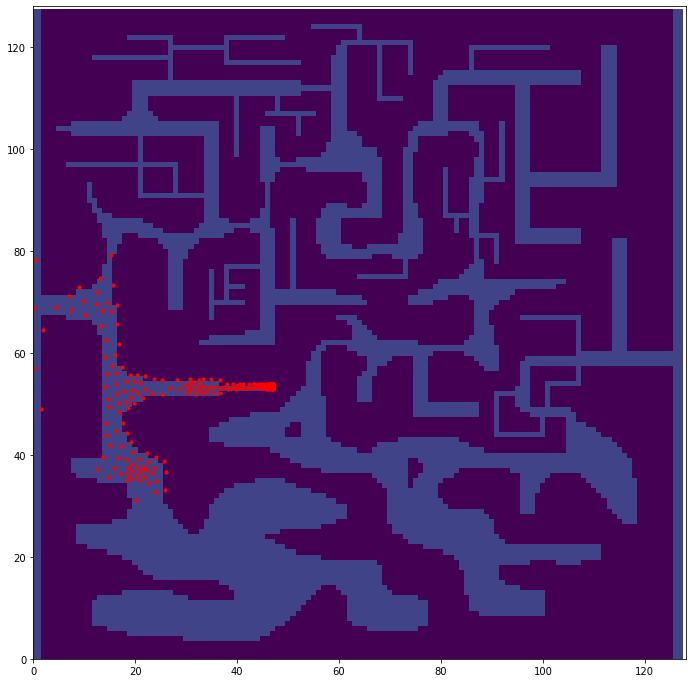

In [29]:
for step in range(1000):       
    zs = np.array([s for s in population])
    dist = np.sqrt(np.sum((zs[np.newaxis,:,:]-zs[:,np.newaxis,:])**2, axis=2))
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])        
    fits = np.array([fitness(p) for p in population])
    
    mindist = np.min(dist, axis=0)
    rank = np.zeros(mindist.shape[0])
    arg = np.argsort(mindist)
    for i in range(mindist.shape[0]):
        rank[arg[i]] = i+1

    rank = rank
    rank = rank/np.sum(rank)
    N = len(population)

    for i in range(N):
        p = mutate2(population[np.random.choice(np.arange(rank.shape[0]), p=rank)].copy())
        f = fitness(p)
        if f>=0:
            pdist = np.sqrt(np.sum((p[np.newaxis,np.newaxis,:]-zs[:,np.newaxis,:])**2,axis=2))

            j = np.random.randint(len(population))
            sp1 = np.arange(len(population))
            sp2 = sp1.copy()
            sp2[j] = len(population)
            
            tdist = np.concatenate([dist, pdist], axis=1)
            pdist = pdist.transpose(1,0)
            pdist = np.concatenate([pdist, np.array([[1e9]])], axis=1)
            tdist = np.concatenate([tdist, pdist], axis=0)
            
            min1 = np.min(tdist[sp1[np.newaxis,:], sp1[:,np.newaxis]],axis=0).mean()
            min2 = np.min(tdist[sp2[np.newaxis,:], sp2[:,np.newaxis]],axis=0).mean()
            
            min1 += 0.1*diminishingMean(fits)
            fits2 = copy.deepcopy(fits)
            fits2[j] = f
            min2 += 0.1*diminishingMean(fits2)
            
            if min2>min1:
                population[j] = p
                dist = tdist[sp2[np.newaxis,:], sp2[:,np.newaxis]]
                fits = fits2
           # population.append(p)
            
    if step%10 == 0:
        plt.clf()
        plt.imshow(maze, vmin=0,vmax=5)
        plt.scatter(np.array(population)[:,1], np.array(population)[:,0], c='r', s=10)
        plt.xlim(0,128)
        plt.ylim(0,128)
        plt.gcf().set_size_inches((12,12))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)


# Spanning Population with Anchors

In [211]:
leaders = [np.array([64,0]) for i in range(128)]
population = []
N = 128

mkdir: cannot create directory ‘frames’: File exists


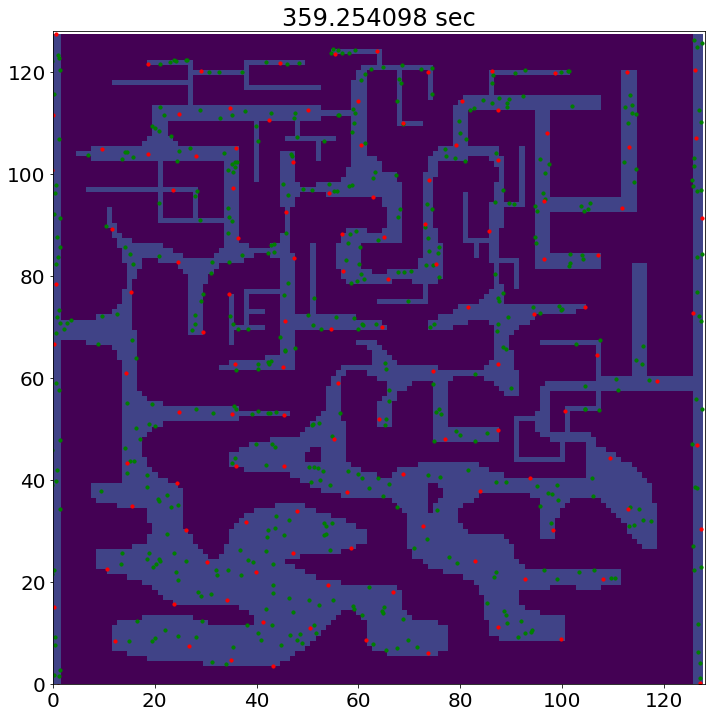

In [212]:
#!mkdir frames
#!rm frames/*.png

frame = 0
t0 = time.time()

plt.rcParams['font.size'] = 20

while time.time()-t0 < 360:
    #if len(population)>0:
    #    population = [population[i].copy() for i in np.random.permutation(len(population))[:N]]
    #else:
    population = []
    i = 0
    while len(population)<4*N:
        population.append(leaders[i%len(leaders)].copy())
        i += 1
        
    fits = [fitness(p) for p in population]
    dists = [np.min(np.sqrt(np.sum((p[np.newaxis,:]-zs[:,:])**2,axis=1))) for p in population]
    
    zs = np.array([s for s in leaders])
    
    for i in range(200):
        for j in range(len(population)):
            k = np.random.randint(len(population))
            p = mutate2(population[k].copy())
            f = fitness(p)
            
            if f>=0:
                pdist = np.min(np.sqrt(np.sum((p[np.newaxis,:]-zs[:,:])**2,axis=1)))
                
                if (0.1 * fits[k] + dists[k] < 0.1 * f + pdist) or np.random.rand()<0.8:
                    population[k] = p
                    dists[k] = pdist
                    fits[k] = f
                    
        if i%50 == 0:
            plt.clf()
            plt.title("%.6f sec" % (time.time()-t0))
            plt.imshow(maze, vmin=0,vmax=5)
            plt.scatter(np.array(population)[:,1]-0.5, np.array(population)[:,0]-0.5, c='g', s=10)
            plt.scatter(np.array(leaders)[:,1]-0.5, np.array(leaders)[:,0]-0.5, c='r', s=10)
            plt.xlim(0,128)
            plt.ylim(0,128)
            plt.gcf().set_size_inches((12,12))
            plt.gcf().set_facecolor("white")
            plt.savefig("frames/%.6d.png" % frame)
            frame += 1
    
    leaders, score = spanPopulation(N, leaders + population, fitness, steps=2000)
    
    #if score > 2:
    #    N = int(N*1.2)


# Spanning Population with Anchors + Recent Expansion Bias

In [226]:
leaders = [np.array([64,0,1]) for i in range(128)]
population = []
N = 128

mkdir: cannot create directory ‘frames’: File exists


KeyboardInterrupt: 

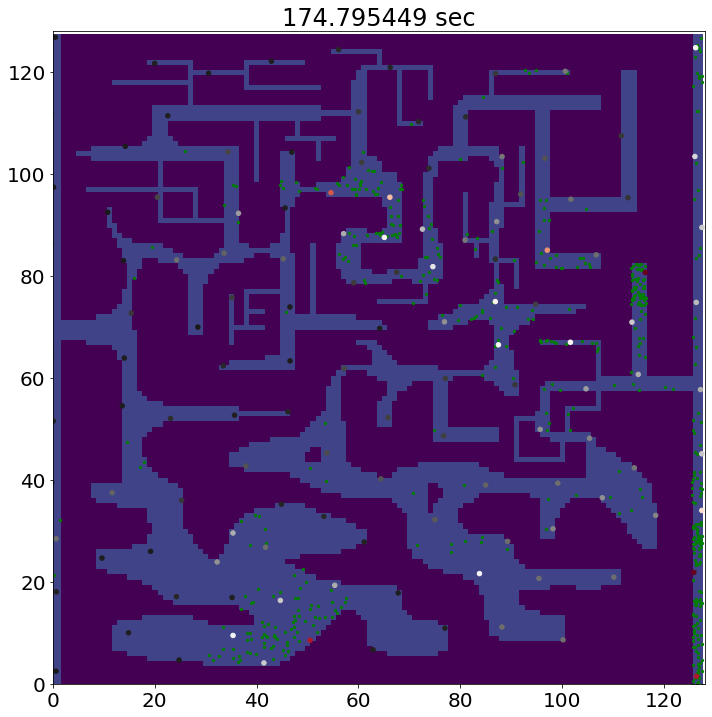

In [227]:
#!mkdir frames
#!rm frames/*.png

frame = 0
t0 = time.time()

plt.rcParams['font.size'] = 20

while time.time()-t0 < 360:
    population = []
    i = 0
    w = np.array([l[2] for l in leaders])**2
    w = w/np.sum(w)
    
    while len(population)<4*N:        
        population.append(leaders[np.random.choice(np.arange(len(leaders)), p=w)].copy())
        i += 1
    
    for p in population:
        p[2] = 1
        
    fits = [fitness(p) for p in population]
    dists = [np.min(np.sqrt(np.sum((p[np.newaxis,:2]-zs[:,:2])**2,axis=1))) for p in population]
    
    zs = np.array([s for s in leaders])
    
    for i in range(200):
        for j in range(len(population)):
            k = np.random.randint(len(population))
            p = mutate(population[k].copy())
            f = fitness(p)
            
            if f>=0:
                pdist = np.min(np.sqrt(np.sum((p[np.newaxis,:2]-zs[:,:2])**2,axis=1)))
                
                if (0.1 * fits[k] + dists[k] < 0.1 * f + pdist) or np.random.rand()<0.8:
                    population[k] = p
                    dists[k] = pdist
                    fits[k] = f
                    
        if i%50 == 0:
            plt.clf()
            plt.title("%.6f sec" % (time.time()-t0))
            plt.imshow(maze, vmin=0,vmax=5)
            plt.scatter(np.array(population)[:,1]-0.5, np.array(population)[:,0]-0.5, c='g', s=5)
            plt.scatter(np.array(leaders)[:,1]-0.5, np.array(leaders)[:,0]-0.5, c=np.array(leaders)[:,2], cmap=plt.cm.RdGy_r, s=20)
            plt.xlim(0,128)
            plt.ylim(0,128)
            plt.gcf().set_size_inches((12,12))
            plt.gcf().set_facecolor("white")
            plt.savefig("frames/%.6d.png" % frame)
            frame += 1
    
    leaders, score = spanPopulation(N, leaders + population, fitness, steps=2000)
    for l in leaders:
        l[2] *= 0.9
        
    #if score > 2:
    #    N = int(N*1.2)
